In [524]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
import time
from collections import OrderedDict

warnings.filterwarnings("ignore")

# DATA LOAD AND CLEAN

In [41]:
btc = pd.read_csv("C:/paspaldzhiev/personal/msc data science/!summerschool2025/Bitcoin Historical Data (3).csv")

In [42]:
btc.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,03/24/2024,"67,211.9","64,036.5","67,587.8","63,812.9",65.59K,4.96%
1,03/23/2024,"64,037.8","63,785.6","65,972.4","63,074.9",35.11K,0.40%
2,03/22/2024,"63,785.5","65,501.5","66,633.3","62,328.3",72.43K,-2.62%
3,03/21/2024,"65,503.8","67,860.0","68,161.7","64,616.1",75.26K,-3.46%
4,03/20/2024,"67,854.0","62,046.8","68,029.5","60,850.9",133.53K,9.35%


In [43]:
for col in btc.columns:
    if btc[col].dtype == 'object':
        # Remove commas, percent signs, and handle 'K' for thousands in 'Vol.'
        btc[col] = (
            btc[col]
            .str.replace(',', '', regex=False)
            .str.replace('%', '', regex=False)
            .str.replace('K', 'e3', regex=False)  # convert 'K' to scientific notation
        )
        # Attempt to convert to numeric
        btc[col] = pd.to_numeric(btc[col], errors='ignore')

# Convert 'Date' separately to datetime if needed
btc['Date'] = pd.to_datetime(btc['Date'], format="%m/%d/%Y")

# Convert all other columns to numeric (in case some remain as strings)
for col in btc.columns.drop('Date'):
    btc[col] = pd.to_numeric(btc[col], errors='coerce')

btc.rename(columns={"Change %":"Returns"}, inplace=True)

btc = btc.set_index('Date')
btc.index = pd.to_datetime(btc.index)
btc.asfreq('D')
btc = btc.sort_index()

print(btc.dtypes)
print(btc.head())

Price      float64
Open       float64
High       float64
Low        float64
Vol.       float64
Returns    float64
dtype: object
            Price  Open  High  Low    Vol.  Returns
Date                                               
2010-07-18    0.1   0.0   0.1  0.1    80.0      0.0
2010-07-19    0.1   0.1   0.1  0.1   570.0      0.0
2010-07-20    0.1   0.1   0.1  0.1   260.0      0.0
2010-07-21    0.1   0.1   0.1  0.1   580.0      0.0
2010-07-22    0.1   0.1   0.1  0.1  2160.0      0.0


C:\Users\Ivan\AppData\Local\Temp\ipykernel_4084\4227749586.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  btc[col] = pd.to_numeric(btc[col], errors='ignore')


# VIEW DATA TO CHOOSE SUBSET DATA TO BE USED FOR FORECASTING, TRAINING, TESTING

In [44]:
use = btc[btc.index>'2019']

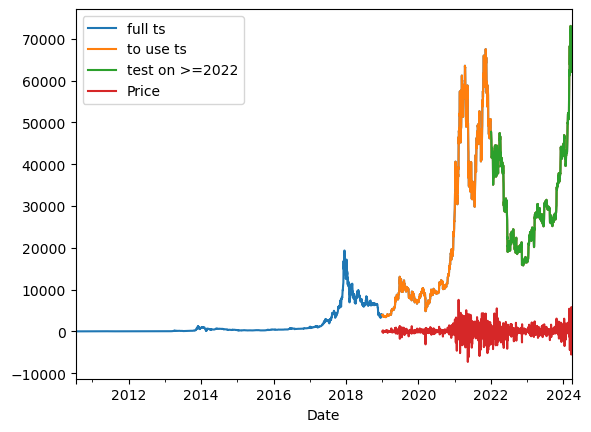

In [45]:
btc['Price'].plot(label='full ts')
use['Price'].plot(label = 'to use ts')
use['Price'][use.index>='2022'].plot(label = 'test on >=2022')
use['Price'].diff().plot()
plt.legend()
plt.show()

## BASIC CHECKS WHICH MODEL TO USE

In [46]:
print('nonstationary ts' if adfuller(use['Price'])[1]>0.05 else 'stationary ts')
print(auto_arima(use['Price']))

nonstationary ts
 ARIMA(2,1,2)(0,0,0)[0] intercept


      lb_stat     lb_pvalue
5    8.775317  1.183687e-01
10  27.615168  2.079753e-03
20  59.362341  8.934501e-06
30  95.356904  9.900225e-09


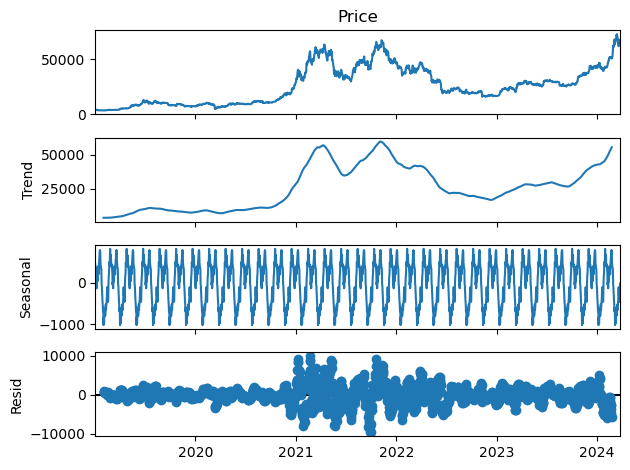

In [129]:
use_decomposed = seasonal_decompose(use['Price'],model='additive',period=60)
use_decomposed.plot()
print(acorr_ljungbox(use_decomposed.resid.diff().dropna(), lags=[5,10,20,30], return_df=True)) # <0.05 = residuals not white noise

In [94]:
splityear = '2023'
train = use['Price'][use.index<=splityear]
test = use['Price'][use.index>splityear]

In [95]:
arima = ARIMA(train,order=(2,1,2),freq='D')
arimafit=arima.fit()

C:\Users\Ivan\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [96]:
forecast=arimafit.forecast(steps=len(test))

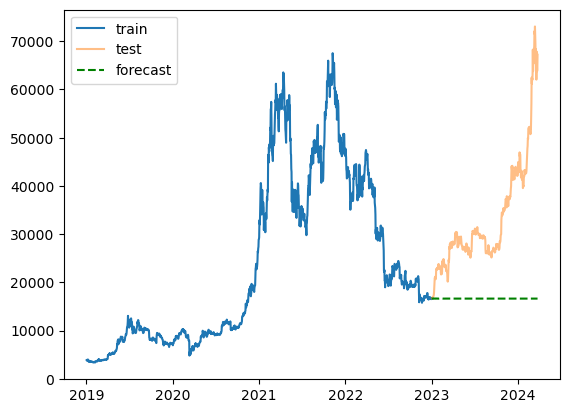

In [97]:
plt.plot(train,label='train')
plt.plot(test,label='test',alpha=0.5)
plt.plot(forecast,'g--',label='forecast')
plt.legend()

In [98]:
print(test),print(forecast)

Date
2023-01-02    16674.3
2023-01-03    16674.2
2023-01-04    16852.1
2023-01-05    16829.8
2023-01-06    16950.9
               ...   
2024-03-20    67854.0
2024-03-21    65503.8
2024-03-22    63785.5
2024-03-23    64037.8
2024-03-24    67211.9
Name: Price, Length: 448, dtype: float64
2023-01-02    16602.974811
2023-01-03    16633.106703
2023-01-04    16672.013487
2023-01-05    16675.597736
2023-01-06    16642.248855
                  ...     
2024-03-20    16642.783439
2024-03-21    16642.783446
2024-03-22    16642.783451
2024-03-23    16642.783449
2024-03-24    16642.783442
Freq: D, Name: predicted_mean, Length: 448, dtype: float64


(None, None)

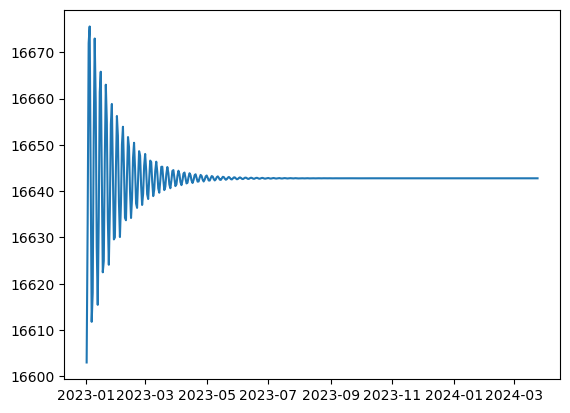

In [99]:
plt.plot(forecast)

# VALIDATION STATISTICS

In [504]:
def MAPE(forecast,obs):
    '''
     mean absolute percentage error
     '''
    error = np.abs((obs - forecast)/obs)
    MAPE = 100./len(obs) * sum(error)
       
    return MAPE

def DS(forecast,obs):
    '''
    directional symmetry
    '''
    obs = obs.reset_index(drop=True)
    forecast = forecast.reset_index(drop=True)
    
    direction_calc = (obs.values[1:] - obs.values[:-1])*(forecast.values[1:] - forecast.values[:-1])
    direction_calc = direction_calc > 0
    DS = 100 * np.sum(direction_calc) / (len(obs) - 1)
    
    return DS

def R(mape_list):
    """
    Calculate the stability coefficient (coefficient of variation) from a list of precomputed MAPE values.

    Parameters:
    - mape_list: list or 1D array of scalar MAPE values (one per validation period).

    Returns:
    - float: stability coefficient R (std / mean)
    """
    mape_array = np.array(mape_list)
    mean_mape = mape_array.mean()
    std_mape = mape_array.std(ddof=1)

    return std_mape / mean_mape if mean_mape != 0 else np.nan

def U(runtimes):
    '''
    computational efficiency
    `runtimes` is passed within `walk_forward_validation`  
    assumes that runtimes is a pandas series that has the same index as the data it has timed
    by default timeit returns values in seconds
    '''
    data_periodicity = pd.tseries.frequencies.to_offset(pd.infer_freq(runtimes.index)).delta.total_seconds() #timestep of data update in seconds
    return np.average(runtimes/data_periodicity)  # timestep for forecast versus data update interval

def Z(DS,MAPE,R,U):
    '''
    combined score from rest of indicators
    '''
    return DS-MAPE-R-U

# WALK-FORWARD VALIDATION

In [518]:
def walk_forward_validation(y, model_class, model_args, train_percent):
    """
    Perform 1-step-ahead walk-forward validation over a single test segment.
    Prepare for calculation of summary statistics specified by case requirements, namely:
    MAPE, directional symmetry, computational efficiency.
    Generalized CV (stability of MAPE over arbitrary set of test periods) is implemented outside this function.
    """
    train_size = int(len(y) * train_percent)
    history = y.iloc[:train_size].copy()
    forecast = []
    obs = []
    direction_flags = []
    step_times = []

    for t in range(train_size, len(y)):
        # Train and predict
        start_time = time.time()
        model = model_class(history.values, **model_args)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        step_time = time.time() - start_time
        
        forecast.append(yhat)

        y_true = y.iloc[t]
        obs.append(y_true)
        
        step_times.append(step_time)
    
        history = pd.concat([history, pd.Series([y_true], index=[y.index[t]])]) 

    forecast = pd.Series(forecast, index=y.index[train_size:])
    obs = pd.Series(obs, index=y.index[train_size:])
    step_times = pd.Series(step_times, index=y.index[train_size:])

    return {
        "forecast": forecast,
        "obs": obs,
        "step_times":step_times
        #"fitted_model"= model_fit, #latest-most fitted model
        #"MAPE": MAPE(forecast,obs)
        #"DS": DS(forecast,obs)
        #"U": U(step_times)
    }

def walk_forward_arbitrary_periods(y, model_class, model_args, train_percent, test_periods):
    """
    Run walk-forward validation across multiple models and user-defined test periods.
    Returns a dictionary of detailed results and a summary statistics DataFrame.
    """
    model_results = []
    MAPEs = []
    DSs = []
    Us = []

    train_size = int(len(y) * train_percent)
    for test_start, test_end in test_periods:
        test_start_loc = y.index.get_loc(test_start)
        test_end_loc = y.index.get_loc(test_end)
        
        train_segment = None
        test_segment = None
        
        if test_start_loc - train_size < 0:
            train_segment = y.iloc[0 : test_start_loc]
            test_segment = y.iloc[test_start_loc : ]
        else:
            train_segment = y.iloc[test_start_loc - train_size : test_start_loc]
            test_segment = y.iloc[test_start_loc : test_end_loc]
        
        combined_segment = pd.concat([train_segment, test_segment])
        result = walk_forward_validation(combined_segment, model_class, model_args, train_percent)
    
        model_results.append(result)
        MAPEs.append(MAPE(result['forecast'],result['obs']))
        DSs.append(DS(result['forecast'],result['obs']))
        Us.append(U(result['step_times']))

    return model_results, np.average(MAPEs), np.average(DSs), R(MAPEs), np.average(Us)

# MODEL ITERATION

In [514]:
model_dict = {"ARIMA_212": (ARIMA, {"order": (2, 1, 2)}
                           ),
              "ARIMA_111": (ARIMA, {"order": (1, 1, 1)}
                           )
             }

test_periods = [("2021-01-01", "2021-02-01"), ("2022-01-01", "2022-02-02")]

validation_statistics = pd.DataFrame(columns=["MAPE","Directional Symmetry", "Model stability", "Computational efficiency", "Combined score"])
validation_statistics.index.name = 'model' # only statistics

validation_results = OrderedDict() # forecast and obs 

train_percent = 0.1 # implement as a user-specified parameter. From task: What is the optimal size of the training data set? (Bonus)

In [559]:
nmodels = len(model_dict.keys()); print(nmodels)
nrows = int(np.floor(np.sqrt(nmodels)))
ncols = int(np.ceil(nmodels / nrows))
    
fig,ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,squeeze=True)
ax = ax.flatten()

def plot_validation_results(ax, model, forecast,obs):
    percent_difference = (obs-forecast)/obs * 100
    ax.plot(percent_difference) # change to obs minus forecast + change ylabel
    ax.set_ylabel('Price in USD: Percentage Difference')
    return ax

for index, (model_name, model_and_params) in enumerate(model_dict.items()):
    results = walk_forward_arbitrary_periods(use['Price'], model_and_params[0],
                                                        model_and_params[1],
                                                        train_percent=train_percent,
                                                        test_periods=test_periods)
    calc_Z = Z(DS=results[2],MAPE=results[1],R=results[3],U=results[4]) #combined score
    validation_statistics.loc[model_name] = [results[1],results[2],results[3],results[4],calc_Z]
    validation_results[model_name] = results[0]

    for fold in validation_results[model_name]:
        forecast = fold['forecast']
        obs = fold['obs']
        plot_validation_results(ax[index],model_name,forecast,obs)
    for i,model_name in enumerate(validation_results.keys()):
        ax[i].set_title('{} one step ahead'.format(model_name))
        ax[i].set_aspect('auto',adjustable='box')

plt.tight_layout()
plt.gcf().autofmt_xdate()
%matplotlib tk
#%matplotlib inline
plt.show()

2


In [558]:
validation_statistics

,MAPE,Directional Symmetry,Model stability,Computational efficiency,Combined score
model,,,,,
ARIMA_212,2.569371,49.623116,0.047372,1.633030e-06,47.006371
ARIMA_111,2.523280,47.607989,0.030667,4.877479e-07,45.054042
